# Multihreaded convolution

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from utils import load_dataset, aggregate, plot_quantiles, plot_surface, plot_common
import matplotlib.pyplot as plt
from IPython.display import Markdown

algorithm = 'convolve'
legend = "2048x2048x{n}x{n}x{n}"
method = 'mpi'
pd.set_option('display.max_rows', 10000)
data = load_dataset('csv', 'convolution_test_2048x2048x')
data = data[data['size'].isin([1, 2, 4, 6, 8]) & data['image_size'].isin([1, 2, 4, 6, 8, 10, 12])]

In [2]:
aggregate(data, method=method, stat='total_op', aggfunc='median', print=True)

## All measured data

size                          1         2        4        6        8
image_size round rank                                               
1.0        0     0        628.0     935.0   1214.0   1355.0   1595.0
                 1          NaN     936.0   1179.0   1288.0   1467.0
                 2          NaN       NaN   1243.0   1313.0   1528.0
                 3          NaN       NaN   1170.0   1231.0   1525.0
                 4          NaN       NaN      NaN   1247.0   1408.0
                 5          NaN       NaN      NaN   1285.0   1413.0
                 6          NaN       NaN      NaN      NaN   1551.0
                 7          NaN       NaN      NaN      NaN   1510.0
           1     0       1183.0    1185.0   1250.0   1461.0   1793.0
                 1          NaN    1169.0   1290.0   1444.0   1804.0
                 2          NaN       NaN   1273.0   1489.0   1826.0
                 3          NaN       NaN   1266.0   1472.0   1841.0
                 4          NaN       NaN      NaN   1433.0   1765.0
                 5          NaN       NaN      NaN   1493.0   1775.0
                 6          NaN       NaN      NaN      NaN   1853.0
                 7          NaN       NaN      NaN      NaN   1815.0
           2     0       1068.0    1261.0   1097.0   1451.0   1634.0
                 1          NaN    1247.0   1117.0   1449.0   1691.0
                 2          NaN       NaN   1133.0   1497.0   1714.0
                 3          NaN       NaN   1104.0   1376.0   1784.0
                 4          NaN       NaN      NaN   1431.0   1757.0
                 5          NaN       NaN      NaN   1465.0   1704.0
                 6          NaN       NaN      NaN      NaN   1730.0
                 7          NaN       NaN      NaN      NaN   1772.0
           3     0       1093.0    1198.0   1457.0   1411.0   1838.0
                 1          NaN    1211.0   1418.0   1424.0   1707.0
                 2          NaN       NaN   1443.0   1466.0   1808.0
                 3          NaN       NaN   1461.0   1361.0   1749.0
                 4          NaN       NaN      NaN   1398.0   1776.0
                 5          NaN       NaN      NaN   1454.0   1761.0
                 6          NaN       NaN      NaN      NaN   1848.0
                 7          NaN       NaN      NaN      NaN   1792.0
           4     0        885.0    1151.0   1242.0   1401.0   1792.0
                 1          NaN    1138.0   1284.0   1414.0   1756.0
                 2          NaN       NaN   1269.0   1436.0   1816.0
                 3          NaN       NaN   1257.0   1350.0   1768.0
                 4          NaN       NaN      NaN   1382.0   1737.0
                 5          NaN       NaN      NaN   1456.0   1742.0
                 6          NaN       NaN      NaN      NaN   1805.0
                 7          NaN       NaN      NaN      NaN   1826.0
           5     0       1153.0    1228.0   1314.0   1413.0   1913.0
                 1          NaN    1216.0   1283.0   1477.0   1874.0
                 2          NaN       NaN   1299.0   1435.0   1852.0
                 3          NaN       NaN   1328.0   1503.0   1948.0
                 4          NaN       NaN      NaN   1447.0   1956.0
                 5          NaN       NaN      NaN   1461.0   1788.0
                 6          NaN       NaN      NaN      NaN   1879.0
                 7          NaN       NaN      NaN      NaN   1932.0
           6     0        910.0    1191.0   1382.0   1459.0   1821.0
                 1          NaN    1229.0   1410.0   1361.0   1777.0
                 2          NaN       NaN   1424.0   1418.0   1768.0
                 3          NaN       NaN   1398.0   1476.0   1852.0
                 4          NaN       NaN      NaN   1352.0   1809.0
                 5          NaN       NaN      NaN   1399.0   1725.0
                 6          NaN       NaN      NaN      NaN   1798.0
                 7          NaN       NaN      NaN      NaN   1865.

## Max node time for each run/round

size                   1       2      4      6      8
image_size round                                     
1.0        0         628     936   1243   1355   1595
           1        1183    1185   1290   1493   1853
           2        1068    1261   1133   1497   1784
           3        1093    1211   1461   1466   1848
           4         885    1151   1284   1456   1826
           5        1153    1228   1328   1503   1956
           6         910    1229   1424   1476   1865
           7         746    1137   1367   1628   1772
           8        1031    1178   1351   1398   1919
           9         995    1242   1318   1419   1758
2.0        0        1032     933   1046   1230   1377
           1        1291    1172   1225   1537   2778
           2        1043    1138   1207   3752   3859
           3        1118    1095   1282   1502   1832
           4        1438    1076   1397   1469   1762
           5        1156    1052   1296   1604   1791
           6        1124     977   1176   1468   1836
           7        1075    1107   1449   1435   1999
           8        1197    1088   1443   1446   1742
           9        1131    1093   1317   1467   1807
4.0        0        4855    3073   2180   1895   1959
           1        4842    3008   2203   2095   2282
           2        4751    6514   2108   1865   2046
           3        4720    2925   2292   1955   2328
           4        4738    2984   2367   2197   2248
           5        4756    2746   2162   1906   2347
           6        4931    2912   2093   1880   2578
           7        4825    2971   2373   2184   2198
           8        4582    3030   2129   1956   2410
           9        4676    2828   2107   1982   2356
6.0        0       14384   10425   5207   4243   5849
           1       14944   10216   5169   6178   3699
           2       14754   10321   6285   3887   5258
           3       16378    8309  12325   4131   4715
           4       17901    8352  12284   6362   4068
           5       14669    8179   5134   3912   4173
           6       14937    9799   5099   4081   3920
           7       15203    8494   5000   4031   4215
           8       15500    8278   5930   4309   4444
           9       14365    9481   5067   3955   4126
8.0        0       55125   21019  10985   9509   8208
           1       33612   19201  10640   8435   7947
           2       36077   18618  11903  10425   8553
           3       32490   18277  11161   8095   8183
           4       34427   18664  10713   8771   8193
           5       34916   19009  10541   8543   8205
           6       34130   18715  11079   8603   8096
           7       35070   18723  10925   8233   7857
           8       34701   19234  11060   8520   7864
           9       33675   19002  10929   8762   8418
10.0       0       66073   37118  20372  22720  14491
           1       78532   37551  22285  25675  14906
           2       68802   37389  23925  18649  14752
           3       68033   37926  20446  16916  14591
           4       69981  115710  21032  15795  31163
           5       81697   36282  20666  18578  15068
           6       67483   35713  23987  28659  20095
           7       67823   36823  22045  34908  23719
           8       67977   36329  46243  15487  14913
           9       66816   87815  31002  16868  15661
12.0       0      117969   62672  42304  28701  33403
           1      116630   63127  62395  30204  26131
           2      119246   64331  34407  31018  39477
           3      116139   64475  34807  30149  27281
           4      132142   62967  38302  29117  28960
           5      121452   64263  40751  30528  27656
           6      121007   61736  40358  27135  25910
           7      111237   75126  34760  28584  24579
           8      120310   61611  36402  29013  25719
           9      140542   66259  38166  30662  24442

size,1,2,4,6,8
image_size,,,,,
1.0,10,10,10,10,10
2.0,10,10,10,10,10
4.0,10,10,10,10,10
6.0,10,10,10,10,10
8.0,10,10,10,10,10
10.0,10,10,10,10,10
12.0,10,10,10,10,10


size,1,2,4,6,8
image_size,,,,,
1.0,1013.0,1198.0,1323.0,1471.0,1837.0
2.0,1127.5,1090.5,1289.0,1468.5,1819.5
4.0,4753.5,2977.5,2171.0,1955.5,2305.0
6.0,14940.5,8987.5,5188.0,4106.0,4194.0
8.0,34564.0,18862.5,10957.0,8573.0,8188.0
10.0,68005.0,37253.5,22165.0,18613.5,14990.5
12.0,119778.0,63695.0,38234.0,29633.0,26706.0


## Speedup

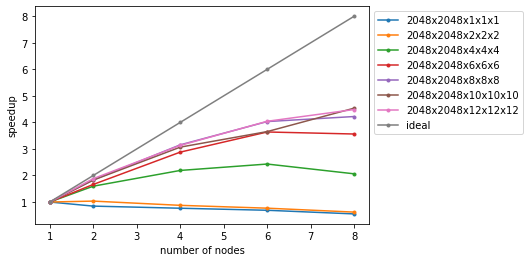

## Total time with 0.2quantile, 0.8quantile

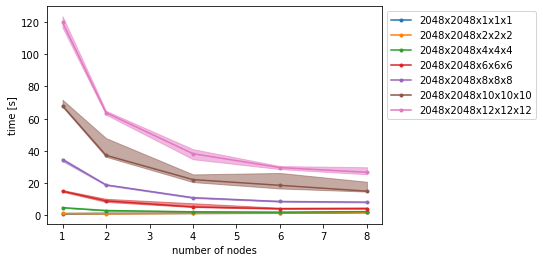

## Time as a function of image size and number of nodes

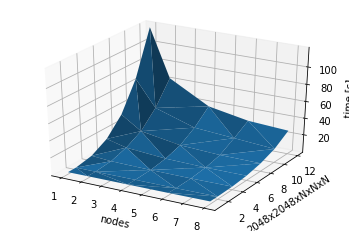

## MPI Gahering time

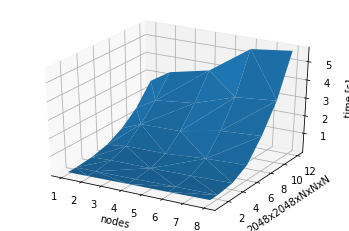

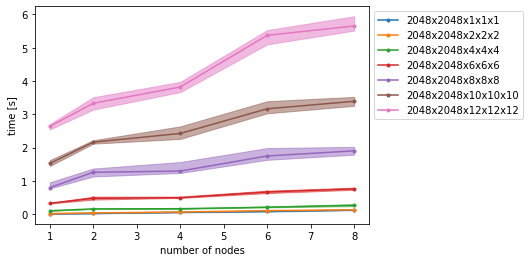

## barrier - waiting for all nodes before result transfer

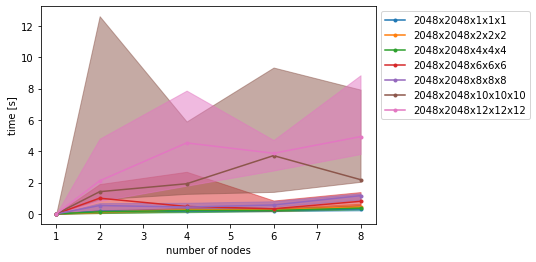

## Dataset read time

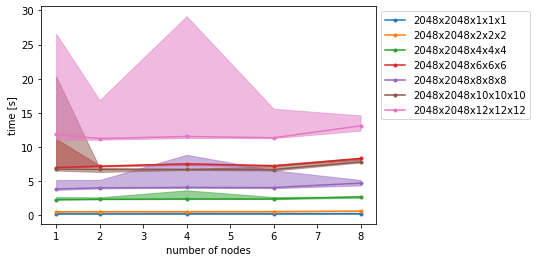

## Dataset write time

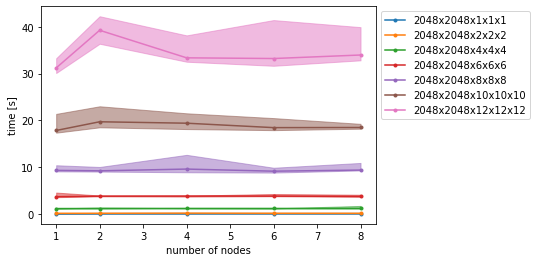

In [3]:
plot_common(data, algorithm=algorithm, method=method, legend=legend)